# Clustering
We utilized clustering to create user and item clusters as a way to further experiment with classical recommendation systems like ALS, SVD++ and NMF. Through clustering we improved computational efficiency by minimizing our search space. Clustering was done through the use of uniform manifold approximation and projection, or UMAP, and scikit-learn. 

In [1]:
import pandas as pd
import clustering_modules as cm

## Clustering News
For news clustering, we first vectorized the titles and abstracts with scikit-learns TF-IDF and BOW vectorizers. Afterwards, we performed dimension reduction to two components with UMAP under both hellinger and euclidean distance metrics, then performed clustering of the results with HDBSCAN and Kmeans.

In [3]:
cm.item_cluster()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Findings
As visible above, hdbscan classified a lot of items as noise. Since our goal was to simply minimize the search space we avoided using clusters created by hdbscan and instead focused on using clusters created from kmeans. We can see that under the hellinger distance metric there are less outliers and while clusters created for bag of words are more tightly packed together, tf-idf had larger cluster size. Ultimately we chose to apply clusters created by kmeans on tf-idf embeddings under the hellinger distance metric. Going beyond how clusters appear visually, below we examine a couple titles belonging to cluster 2. Notably, titles all relate to each other and seem to be referring to sports. Pleased with the results we moved on to clustering users.

In [2]:
news_text = pd.read_csv('../MIND_large/csv/clustered_items.csv')
news_text[news_text['labels'] == 2]['title'].head().to_list()

FileNotFoundError: [Errno 2] No such file or directory: '../MIND_large/csv/clustered_items.csv'

In [28]:
news_text.to_csv('../MIND_large/csv/news_cluster_labels.csv')

## Clustering Users
For user clustering we calculated and normalized their preferences for specific categories and found the median time of day they interact. Similarly to news, we performed dimension reduction to two components with UMAP under a euclidean and cosine distance metric, then performed clustering of the results with Kmeans.

In [2]:
import numpy as np
import sklearn.cluster as cluster

In [3]:
user = pd.read_csv('../MIND_large/80_20/user_prof_train.csv', index_col=0)

In [3]:
metrics = ['euclidean','cosine']
parameters = [(0.0, 30),(0.0, 50),(0.1, 30),(0.1,50)]
embeddings = []
for metric in metrics:
    for p_comb in parameters:
        min_dist, n_neigh = p_comb
        embeddings.append(np.load(f'../MIND_large/80_20/user_embeddings_{metric}_{min_dist}_{n_neigh}.npy'))
kmeans_labels = [cluster.KMeans(n_clusters=50,n_init='auto').fit_predict(embedding) for embedding in embeddings]

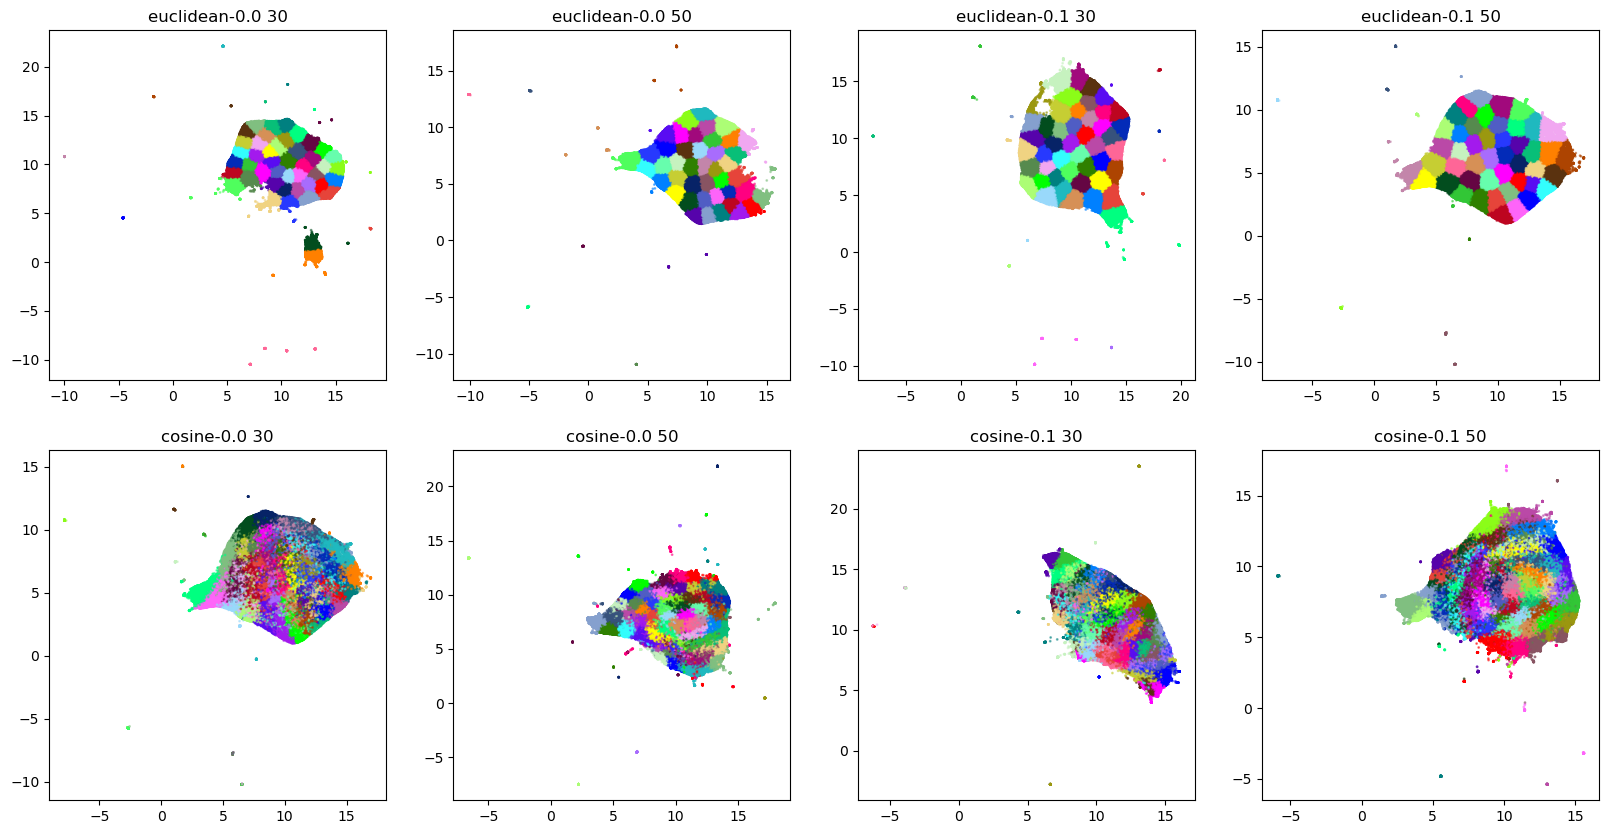

In [4]:
cm.plot_user_clusters_params(embeddings, kmeans_labels, metrics, parameters)

From the graphs above it appears the best performer is euclidean distance metric with, 0.1 minimum distance and 50 number of neighbors. Cosine seems to lose a lot of defined boundaries of the clusters. While changing the parameters of the umap functions does also give very promising looking clusters, the others' shapes appear slightly less defined and uniform.

Similar to our analysis of item clusters we wanted to get a first hand look at out clustering results here are the first 5 users belongs to cluster 7. The users seem to all have about news score of around 0.30, a sports score of 0.1, a finance score of about 0.05, and a , median score of 0.5 (translating to most of their interactions occuring at about noon).

In [9]:
user["cluster"] = kmeans_labels[3]
user[user["cluster"] == 7].head()

,user_id,news,entertainment,finance,video,tv,movies,music,lifestyle,sports,travel,autos,health,foodanddrink,weather,middleeast,kids,games,median,cluster
106,U100433,0.271277,0.031915,0.074468,0.047872,0.037234,0.026596,0.010638,0.095745,0.159574,0.047872,0.047872,0.069149,0.058511,0.021277,0.0,0.0,0.0,0.458333,7
127,U100506,0.283582,0.044776,0.059701,0.000000,0.074627,0.074627,0.029851,0.104478,0.134328,0.014925,0.044776,0.014925,0.104478,0.014925,0.0,0.0,0.0,0.500000,7
172,U100726,0.229773,0.038835,0.055016,0.042071,0.045307,0.051780,0.022654,0.165049,0.090615,0.051780,0.042071,0.067961,0.090615,0.006472,0.0,0.0,0.0,0.458333,7
186,U10079,0.311111,0.037037,0.062963,0.055556,0.048148,0.033333,0.022222,0.092593,0.081481,0.055556,0.051852,0.070370,0.062963,0.014815,0.0,0.0,0.0,0.500000,7
223,U100909,0.244898,0.051020,0.051020,0.061224,0.040816,0.051020,0.030612,0.122449,0.112245,0.051020,0.040816,0.051020,0.081633,0.010204,0.0,0.0,0.0,0.458333,7


In [3]:
def create_big_boy():
    full = pd.DataFrame()
    for i in range(4):
        df = pd.read_csv(f"../MIND_large/csv/tensorflow_dataset_chunk{i}.csv", index_col=0)
        full = pd.concat([full, df])
    return full
full_tf = create_big_boy()
news_text = pd.read_csv('../MIND_large/csv/news_cluster_labels.csv')
all_ratings2 = full_tf.groupby('user_id')['news_id'].apply(list).reset_index()
scores = full_tf.groupby('user_id')['score'].apply(list).reset_index()
all_ratings2['scores'] = scores['score']

In [5]:
all_ratings2.head()

,user_id,news_id,scores
0,U1,"[N14639, N27258, N63237, N112729, N42180, N109...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,U100,"[N99587, N61339, N129790, N12721, N100405, N10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,U1000,"[N33446, N20131, N65823, N65823, N111503, N399...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
3,U10000,"[N34918, N81659, N128643, N97343, N103301, N92...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,U100005,"[N53796, N41484, N95178, N27038, N72493, N3850...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


Note for later: go over indexing and make sure everything is lining up properly 

In [15]:
item_clusters = {item : cluster for item, cluster in zip(news_text['news_id'], news_text['labels'])}

def create_item_cluster_mat(rating_mat, num_users = 255990):
    """
    Creates a matrix utilizing item clusters to improve calculation efficiency.
    """
    # for the hash tables we want to have one that builds the matrix, cluster : scores []
    # and one that can be used to check which cluster something belongs to
    # rename rating mat
    matrix = {cluster : np.full(num_users, 0, dtype='int8') for cluster in range(30)} 
    counter = 0
    for user, ratings, score in zip(rating_mat['user_id'], rating_mat['news_id'], rating_mat['scores']):
        for index in range(len(ratings)):
            news_id = ratings[index]
            num = score[index]
            if num != 0:    
                matrix[item_clusters[news_id]][counter] += 1
        counter += 1
    return np.column_stack(list(matrix.values()))
matrix = create_item_cluster_mat(all_ratings2)
np.save('../MIND_large/csv/item_cluster_mat.npy', matrix)

In [12]:
user_clustered = pd.read_csv('../MIND_large/csv/full_user_clusters.csv')

In [13]:
user_clustered['cluster'].unique()

array([6, 2, 1, 3, 7, 9, 4, 0, 8, 5])

In [16]:

user_clusters= {user : cluster for user, cluster in zip(user_clustered['user_id'], user_clustered['cluster'])}
def create_user_cluster_mat(rating_mat, num_user_clusters=10):
    """
    Creates a matrix utilizing user clusters to improve calculation efficiency.
    """
    matrix = {news_id : np.full(num_user_clusters, 0, dtype='int8') for news_id in news_text['news_id']}
    # will have clusters as rows, so need to determine length of clusters applied to the dataset 
    for user, ratings, score in zip(rating_mat['user_id'], rating_mat['news_id'], rating_mat['scores']):
        cluster = user_clustered[user]
        for index in range(len(ratings)):
            news_id = ratings[index]
            num = score[index]
        if num != 0:    
            matrix[item_clusters[news_id]][cluster] += 1
        
    return np.column_stack(list(matrix.values()))   
    
matrix = create_item_cluster_mat(all_ratings2)
np.save('../MIND_large/csv/user_cluster_mat.npy', matrix)

In [ ]:
def subset_clusters(user_cluster, item_cluster):
    """
    when given user and item clusters, subsets the matrix for users and items in the cluster 
    """
    # Subset df for either cluster and thats it? might have to do some similarity or distance metric, or get the
    # highest rated news cluster from the other matrix for all users (post normalization? probably not?)
    # so starting with user clusters then, we would get the group of users, find the highest rated news cluster amongst them
    # and then we would have the space minimized to that group of users and thier news cluster with the most ratings, 
    # what if there is the same number of ratings for a different news cluster? then we would have to evaluate the next steps off of
    # a secondary conditional 
    